In [199]:
import math
import random # библиотека функций для генерации случайных значений
# Сторонние библиотеки
import numpy as np # библиотека функций для работы с матрицами
""" ---Раздел описаний--- """
""" --Описание класса Network--"""
class Network(object): # используется для описания нейронной сети
    def __init__(self, sizes): # конструктор класса
# self – указатель на объект класса
# sizes – список размеров слоев нейронной сети
        self.num_layers = len(sizes) # задаем количество слоев нейронной сети
        self.sizes = sizes # задаем список размеров слоев нейронной сети
        self.biases = [np.random.randn(y, 1)*math.sqrt(2/y) for y in sizes[1:]] # задаем случайные начальные смещения
        self.weights = [np.random.randn(y, x)*math.sqrt(2/y) for x, y in zip(sizes[:-1], sizes[1:])] # задаем случайные начальные веса связей
    def sigmoid(self, z):
      return 1 / (1 + np.exp(-z))

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a)+b)
        return a
    def SGD( # Стохастический градиентный спуск
        self # указатель на объект класса
        , training_data # обучающая выборка
        , epochs # количество эпох обучения
        , mini_batch_size # размер подвыборки
        , eta # скорость обучения
        , test_data # тестирующая выборка
        ):
        test_data = list(test_data) # создаем список объектов тестирующей выборки
        n_test = len(test_data) # вычисляем длину тестирующей выборки
        training_data = list(training_data) # создаем список объектов обучающей выборки
        n = len(training_data) # вычисляем размер обучающей выборки
        for j in range(epochs): # цикл по эпохам
            random.shuffle(training_data) # перемешиваем элементы обучающей выборки
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)] # создаем подвыборки
            for mini_batch in mini_batches: # цикл по подвыборкам
              #print(len(mini_batch[0][0]))
              self.update_mini_batch(mini_batch, eta) # один шаг градиентного спуска
            print ("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test)) # смотрим прогресс в обучении
    def update_mini_batch( # Шаг градиентного спуска
        self # указатель на объект класса
        , mini_batch # подвыборка
        , eta # скорость обучения
        ):
        nabla_b = [np.zeros(b.shape) for b in self.biases] # список градиентов dC/db для каждого слоя (первоначально заполняются нулями)
        nabla_w = [np.zeros(w.shape) for w in self.weights] # список градиентов dC/dw для каждого слоя (первоначально заполняются нулями)
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y) # послойно вычисляем градиенты dC/db и dC/dw для текущего прецедента (x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)] # суммируем градиенты dC/db для различных прецедентов текущей подвыборки
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)] # суммируем градиенты dC/dw для различных прецедентов текущей подвыборки
        self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)] # обновляем все веса w нейронной сети
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)] # обновляем все смещения b нейронной сети
    def backprop( # Алгоритм обратного распространения
        self # указатель на объект класса  
      ,x # вектор входных сигналов , 
      ,y # ожидаемый вектор выходных сигналов
      ):
        nabla_b = [np.zeros(b.shape) for b in self.biases] # список градиентов dC/db для каждого слоя (первоначально заполняются нулями)
        nabla_w = [np.zeros(w.shape) for w in self.weights] # список градиентов dC/dw для каждого слоя (первоначально заполняются нулями)
        # определение переменных
        activation = x # выходные сигналы слоя (первоначально соответствует выходным сигналам 1-го слоя или входным сигналам сети)
        activations = [x] # список выходных сигналов по всем слоям (первоначально содержит только выходные сигналы 1-го слоя)
        zs = [] # список активационных потенциалов по всем слоям (первоначально пуст)
        # прямое распространение
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b # считаем активационные потенциалы текущего слоя
            zs.append(z) # добавляем элемент (активационные потенциалы слоя) в конец списка
            activation = self.sigmoid(z) # считаем выходные сигналы текущего слоя, применяя сигмоидальную функцию активации к активационным потенциалам слоя
            activations.append(activation) # добавляем элемент (выходные сигналы слоя) в конец списка
  # обратное распространение
        delta = self.cost_derivative(activations[-1], y) * self.sigmoid_prime(zs[-1]) # считаем меру влияния нейронов выходного слоя L на величину ошибки (BP1)
        nabla_b[-1] = delta # градиент dC/db для слоя L (BP3)
        nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # градиент dC/dw для слоя L (BP4)
        for l in range(2, self.num_layers):
          z = zs[-l] # активационные потенциалы l-го слоя (двигаемся по списку справа налево)
          sp = self.sigmoid_prime(z) # считаем сигмоидальную функцию от активационных потенциалов l-го слоя
          delta = np.dot(self.weights[-l+1].transpose(), delta) * sp # считаем меру влияния нейронов l-го слоя на величину ошибки (BP2)
          nabla_b[-l] = delta # градиент dC/db для l-го слоя (BP3)
          nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())# градиент dC/dw для l-го слоя (BP4)
        return (nabla_b, nabla_w)
    def evaluate(self, test_data):
      test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
      correct_predictions = sum(int(x == y) for (x, y) in test_results)
      total_tests = len(test_data)
      accuracy = correct_predictions / total_tests
      return accuracy
    def cost_derivative(self, output_activations, y): # Вычисление частных производных стоимостной функции по выходным сигналам последнего слоя
      return (output_activations-y)
    def sigmoid_prime(self,z):# Производная сигмоидальной функции
      return 1/np.cosh(z)**2
    # def forward_propagate(self, row):
    #     activation = row
    #     for b, w in zip(self.biases, self.weights):
    #         z = np.dot(w, activation)+b# zs.append(z)
    #         activation = self.sigmoid(z)
    #         activations.append(activation)
	  #     activation = activations
    #     activations=[]
	  #   return activation

In [200]:
# ! wget https://github.com/GregVial/CoMNIST/blob/master/images/Cyrillic.zip
# ! unzip Cyrilic.zip

Создайте нейронную сеть для распознавания рукописных цифр:


Запустите процедуру обучения созданной нейронной сети, включающую 30 эпох:

Found 4737 files belonging to 10 classes.


2023-11-15 18:12:05.506016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4737]
	 [[{{node Placeholder/_0}}]]
2023-11-15 18:12:05.506240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4737]
	 [[{{node Placeholder/_0}}]]


[[ 4]
 [ 5]
 [10]
 ...
 [ 2]
 [ 7]
 [ 4]]
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [

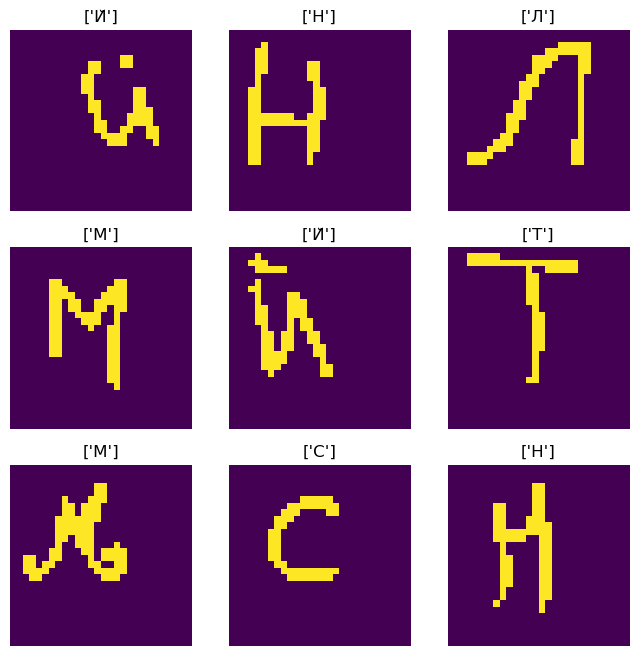

In [201]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

image_size = (28, 28)
dataset = tf.keras.utils.image_dataset_from_directory('Cyrillic',
                                       seed=42,
                                       color_mode="rgba",
                                       batch_size=1,
                                       image_size=image_size)

class_names = dataset.class_names

###############################
data = []
Y = []
for images, labels in dataset.take(4549):
  for i in range(1):
    img = Image.fromarray(images[i].numpy().astype("uint8").squeeze())
    img = img.convert("LA")
    #img = images[i].numpy().astype("uint8").squeeze().convert("LA")
    imgData = np.asarray(img)
    #print(imgData[0][0][0])

    imgData_A=[]

    for row in imgData:
        imgData_A.extend(row[:,1])
        
    imgData_A=np.reshape(imgData_A,-1)

    #Pixels higher than this will be 1. Otherwise 0.
    THRESHOLD_VALUE=0
    thresholdedData=0

    thresholdedData = (imgData_A <= THRESHOLD_VALUE) * 1.0

    unique, counts = np.unique(thresholdedData, return_counts=True)
    result = np.column_stack((unique, counts)) 

    thresholdedData=np.reshape(thresholdedData,(28,28))
    
    data.append(thresholdedData)
    Y.append([class_names[labels[i]]])

#############################################
for i in range(len(data)):
  for j in range(len(data[i])):
    for z in range(len(data[i][j])):
      if (data[i][j][z] == 1):
        data[i][j][z] = 0
      else:
        data[i][j][z] = 1
############################################
plt.figure(figsize=(8,8))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(data[i])
  plt.title(Y[i])
  plt.axis('off')
#############################################
s = np.array(data.copy())
vec_data = []
for i in range(len(data)):
  vec_data.append(s[i].reshape(-1,1))
#############################################
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vec_data, Y, test_size=0.4)

#############################################
X_train_new = []
for i in range(len(X_train)):
  Vec = []
  for j in range(len(X_train[i])):
    Vec.append(X_train[i][j][0])
  X_train_new.append(Vec)

X_test_new = []
for i in range(len(X_test)):
  Vec = []
  for j in range(len(X_test[i])):
    Vec.append(X_test[i][j][0])
  X_test_new.append(Vec)

X_train = X_train_new.copy()
X_test = X_test_new.copy()
###############################################
class_mapping = {'Й': 0, 'К': 1, 'Л': 2, 'М': 3, 'Н': 4, 'О': 5, 'П': 6, 'Р': 7, 'С': 8, 'Т': 9}

# Add the missing character
class_mapping = {'Й': 0, 'К': 1, 'Л': 2, 'М': 3, 'Н': 4, 'О': 5, 'П': 6, 'Р': 7, 'С': 8, 'Т': 9}

# Add the missing character
class_mapping = {'Й': 0, 'К': 1, 'Л': 2, 'М': 3, 'Н': 4, 'О': 5, 'П': 6, 'Р': 7, 'С': 8, 'Т': 9, 'Й': 10}

# Convert class labels to integers in y_train and y_test
y_train = [[class_mapping.get(class_label, class_label) for class_label in sample] for sample in y_train]
y_test = [[class_mapping.get(class_label, class_label) for class_label in sample] for sample in y_test]

y_train = np.array(y_train)
y_test = np.array(y_test)

############################

print(y_test)
def vectorized_result(j):
    e = np.zeros((10, 1))
    try:
        e[j] = 1.0
    except IndexError:
        print(f"Error: Index {j} is out of bounds for axis 0 with size 10.")
        print("Make sure your labels are in the expected range (0 to 9).")
    return e



def load_data_wrapper(n):
  training_inputs = [((np.reshape(x, (n,1)) > 0) * 1.0) for x in (X_train_new)]
  training_results = [vectorized_result(y) for y in (y_train)]
  training_data = list (zip(training_inputs, training_results))
  test_inputs = [((np.reshape(x, (n,1)) > 0) * 1.0) for x in (X_test_new)]
  test_data = list(zip(test_inputs,y_test))
  return (training_data, test_data)

training_data, test_data = load_data_wrapper(784)


Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 10.
Make sure your labels are in the expected range (0 to 9).
Error: Index [10] is out of bounds for axis 0 with size 

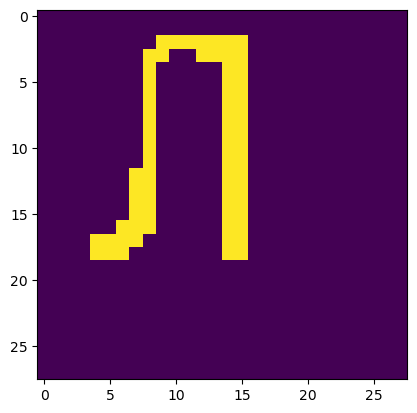

In [202]:
import matplotlib.pyplot as plt
training_data,test_data = load_data_wrapper(784)
lll8=np.reshape(training_data[444][0],(28,28))
plt.imshow(lll8)
plt.show()

In [203]:
import math
net = Network([784, 30, 10])
""" Вывод результата на экран: """ 
print('Сеть net:') 
print('Количетво слоев:', net.num_layers) 
for i in range(net.num_layers): 
    print('Количество нейронов в слое', i,':',net.sizes[i]) 
for i in range(net.num_layers-1): 
    print('W_',i+1,':') 
    print(np.round(net.weights[i],2)) 
    print('b_',i+1,':') 
    print(np.round(net.biases[i],2))
    

Сеть net:
Количетво слоев: 3
Количество нейронов в слое 0 : 784
Количество нейронов в слое 1 : 30
Количество нейронов в слое 2 : 10
W_ 1 :
[[ 0.18 -0.25 -0.08 ... -0.46 -0.12 -0.56]
 [ 0.4   0.01 -0.25 ... -0.25  0.04 -0.27]
 [-0.01  0.14 -0.45 ...  0.11 -0.23  0.24]
 ...
 [ 0.16  0.52  0.13 ... -0.25  0.22  0.12]
 [-0.11  0.55  0.3  ...  0.16 -0.05 -0.22]
 [-0.24  0.23 -0.17 ... -0.22  0.09 -0.06]]
b_ 1 :
[[-0.47]
 [-0.17]
 [-0.08]
 [ 0.21]
 [-0.2 ]
 [-0.14]
 [-0.07]
 [ 0.38]
 [-0.15]
 [ 0.21]
 [ 0.22]
 [ 0.9 ]
 [-0.26]
 [ 0.21]
 [-0.17]
 [ 0.42]
 [ 0.3 ]
 [-0.01]
 [-0.11]
 [-0.75]
 [ 0.29]
 [ 0.03]
 [ 0.12]
 [-0.36]
 [-0.07]
 [ 0.14]
 [-0.17]
 [ 0.24]
 [-0.57]
 [ 0.19]]
W_ 2 :
[[ 0.1  -0.52 -0.38  0.46  0.08 -0.21  0.12 -0.1  -0.15 -0.33 -0.95 -0.07
   0.49  0.66  0.05 -0.06 -0.   -0.37  0.03  0.09 -0.13  0.36  0.29  0.65
   0.25  0.2   0.49 -0.07 -0.44  0.34]
 [ 0.54  0.42  0.48  0.32  0.55 -0.21  0.13  0.16  0.26  0.26 -0.78  0.75
   0.28 -0.05  0.08  0.11  0.1   0.81  0.46  0.06  

In [204]:
net.SGD(training_data, 30, 10, 0.05, test_data=test_data)
#  , training_data # обучающая выборка
#         , epochs # количество эпох обучения
#         , mini_batch_size # размер подвыборки
#         , eta # скорость обучения
#         , test_data # тестирующая выборка

Epoch 0: 0.1967032967032967 / 1820
Epoch 1: 0.25769230769230766 / 1820
Epoch 2: 0.3208791208791209 / 1820
Epoch 3: 0.34065934065934067 / 1820
Epoch 4: 0.3686813186813187 / 1820
Epoch 5: 0.3769230769230769 / 1820
Epoch 6: 0.389010989010989 / 1820
Epoch 7: 0.40274725274725276 / 1820
Epoch 8: 0.4076923076923077 / 1820
Epoch 9: 0.41318681318681316 / 1820
Epoch 10: 0.41703296703296705 / 1820
Epoch 11: 0.4269230769230769 / 1820
Epoch 12: 0.43846153846153846 / 1820
Epoch 13: 0.4582417582417582 / 1820
Epoch 14: 0.4818681318681319 / 1820
Epoch 15: 0.49230769230769234 / 1820
Epoch 16: 0.5010989010989011 / 1820
Epoch 17: 0.5032967032967033 / 1820
Epoch 18: 0.5082417582417582 / 1820
Epoch 19: 0.5175824175824176 / 1820
Epoch 20: 0.5203296703296704 / 1820
Epoch 21: 0.5263736263736264 / 1820
Epoch 22: 0.5241758241758242 / 1820
Epoch 23: 0.5318681318681319 / 1820
Epoch 24: 0.5318681318681319 / 1820
Epoch 25: 0.539010989010989 / 1820
Epoch 26: 0.5368131868131868 / 1820
Epoch 27: 0.5412087912087912 / 18

In [205]:
from sklearn.metrics import confusion_matrix

# Forward propagate input to a network output
def forward_propagate(net, row):
    inputs = row
    for i in range(net.num_layers-1):
        new_inputs = []
        for b, w in zip(net.biases[i], net.weights[i]):
            activation = np.dot(w,inputs)+b
            out = net.sigmoid(activation)
            new_inputs.append(out)
        inputs = new_inputs
    return new_inputs
		  


# Make a prediction with a network
def predict(net, row):
    outputs = forward_propagate(net, row)
    return outputs.index(max(outputs))

i=-1
X_train1=[]
thresholdedData=[]

for i in range(len(X_train)):
    row=np.reshape(X_train[i], (1,784))
    thresholdedData = (row > 0) * 1.0
    X_train1.extend(thresholdedData)


for i in range(len(X_train1)):
    prediction = predict(net,X_train1[i])
    if (i==0):
      predictTrain = np.array([[prediction]])
    else:
      predictTrain =np.append(predictTrain,[[prediction]],axis=0)

print(confusion_matrix(y_train, predictTrain))



i=-1
for row in X_test:
    i=i+1
    prediction = predict(net, row)
    if (i==0):
      predictTest = np.array([[prediction]])
    else:
      predictTest =np.append(predictTest,[[prediction]],axis=0)

print(confusion_matrix(y_test, predictTest))



[[  0  27  47 105   4  22  19  31  11   0]
 [  0 210   9   6   3   8   2   7   2   0]
 [  0   6 232   5   7   6   4   3   7   0]
 [  0  21 120  64  13  49  12   8   7   0]
 [  0   9  11   1 227  10  10  11   2   0]
 [  0  16  24  11   7 171  24   7  11   0]
 [  0   0   2   2  11   5 247   0   5   0]
 [  0   1   1   1   2   3   5 276   5   0]
 [  0   8  22   4   5  13  13   7 194   0]
 [  0  40  44  36  33  69  26  17   3   0]]
[[  0  12  45  56   1  10  14  18  16   0]
 [  0 141   8   4   5   3   5   2   3   0]
 [  0   9 144   2   4  14   3   1   1   0]
 [  0  16  85  36   9  34   7   8   1   0]
 [  0   5  14   1 116   9   2   9   5   0]
 [  0   9  31   6  12  93  21   5   5   0]
 [  0   2   6   0  10   3 163   3  12   0]
 [  0   5   1   0   3   5   9 166  16   0]
 [  0   4   7   4   5   5   5   6 136   0]
 [  0  35  26  27  30  34  17  14   1   0]]
